# Week 4

Physical environmental variables regressed on seaice.   We start by loading in the different variables and inspecting the data.

In [1]:
import xarray as xr
import pandas as pd
import itertools
from tqdm import tqdm
from modules import *
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# ds = xr.open_mfdataset('processed_data/ERA5-levels/*')

In [3]:
# for variable in ds:
#     if 'level' in ds[variable].dims:
#         for level in ds.level:
#             ds[variable+'_'+str(level.values)] = ds[variable].sel(level=level)
#         ds = ds.drop(variable)
# ds = ds.drop('level')

In [4]:
# seaice = w3.load_data(['seaice'],projection='SouthPolarStereo', temporal_resolution='annual',temporal_decomposition='anomalous',detrend='raw')

In [5]:
# ds = ds.interp(time=seaice.time)
# ds.to_netcdf('processed_data/environmental.nc')

In [6]:
ds = xr.open_dataset('processed_data/environmental.nc')
ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
Data variables:
    si10     (time, y, x) float64 ...
    skt      (time, y, x) float64 ...
    sp       (time, y, x) float64 ...
    ssr      (time, y, x) float64 ...
    ssrd     (time, y, x) float64 ...
    sst      (time, y, x) float64 ...
    t2m      (time, y, x) float64 ...
    u10      (time, y, x) float64 ...
    v10      (time, y, x) float64 ...
    o3_200   (time, y, x) float64 ...
    o3_500   (time, y, x) float64 ...
    o3_700   (time, y, x) float64 ...
    t_200    (time, y, x) float64 ...
    t_500    (time, y, x) float64 ...
    t_700    (time, y, x) float64 ...
    u_200    (time, y, x) float64 ...
    u_500    (time, y, x) float64 ...
    u_700    (time, y, x) float64 ...
    v_200    (time, y, x) float64 ...
    v_500    (time, y, x) float64 ...
    v_700    (time, y, x) float64 ...
    z_200    (time, y, x) float64 ...
    z_500    (time, y, x) float64 ...
    z_700    (time, y, x) float64 ...

In [7]:
ds = xr.open_dataset('processed_data/environmental.nc')
v = [v for v in ds]
correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1].mean(dim=('x','y'))
    vec2 = ds[v2].mean(dim=('x','y'))
#     fig = plt.figure()
#     ax = plt.gca()
#     ax.plot(vec1.time,vec1)
#     ax2 = ax.twinx()
#     ax2.plot([],[])
#     ax2.plot(vec1.time,vec2)
#     plt.title(f'{v1} and {v2}')
#     plt.show()
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:01<00:00,  9.30it/s]


In [8]:
def significant_bold(val, sig_level=0.9):
    bold = 'bold' if val > sig_level or val < -sig_level else ''
    return 'font-weight: %s' % bold

In [9]:
# correlation_matrix.to_latex('H:\\Github/Environmental-Impact-on-Sea-Ice/correlations.tex')
correlation_matrix.style.applymap(significant_bold,sig_level=0.9)

,si10,skt,sp,ssr,ssrd,sst,t2m,u10,v10,o3_200,o3_500,o3_700,t_200,t_500,t_700,u_200,u_500,u_700,v_200,v_500,v_700,z_200,z_500,z_700
si10,1.000000,-0.233104,-0.730160,-0.018405,-0.041777,-0.120237,-0.207301,0.888512,-0.765622,0.037386,0.037383,0.037387,-0.185049,-0.185062,-0.185045,0.676851,0.676851,0.676848,0.322267,0.322278,0.322266,-0.055538,-0.055531,-0.055541
skt,-0.233104,1.000000,0.284035,-0.564810,-0.648627,0.823878,0.996957,-0.318373,0.287448,0.688201,0.688202,0.688200,0.730466,0.730469,0.730465,0.185075,0.185074,0.185074,-0.514421,-0.514437,-0.514403,0.694512,0.694508,0.694513
sp,-0.730160,0.284035,1.000000,-0.061091,-0.037995,0.075637,0.265798,-0.863104,0.689097,-0.023166,-0.023164,-0.023167,0.229015,0.229024,0.229012,-0.495981,-0.495979,-0.495980,-0.378782,-0.378804,-0.378791,0.224582,0.224573,0.224586
ssr,-0.018405,-0.564810,-0.061091,1.000000,0.978953,-0.668839,-0.557640,-0.014704,-0.056302,-0.912934,-0.912935,-0.912934,-0.830709,-0.830696,-0.830715,-0.694034,-0.694031,-0.694036,0.452724,0.452715,0.452706,-0.961908,-0.961910,-0.961907
ssrd,-0.041777,-0.648627,-0.037995,0.978953,1.000000,-0.760720,-0.640320,-0.045026,-0.036820,-0.923746,-0.923748,-0.923747,-0.804665,-0.804653,-0.804672,-0.717387,-0.717385,-0.717389,0.454157,0.454156,0.454132,-0.970764,-0.970766,-0.970763
sst,-0.120237,0.823878,0.075637,-0.668839,-0.760720,1.000000,0.803051,-0.059933,0.113970,0.762217,0.762219,0.762216,0.627434,0.627430,0.627437,0.429718,0.429716,0.429720,-0.449968,-0.449972,-0.449944,0.725416,0.725417,0.725416
t2m,-0.207301,0.996957,0.265798,-0.557640,-0.640320,0.803051,1.000000,-0.299136,0.259470,0.682396,0.682397,0.682395,0.735805,0.735808,0.735804,0.191265,0.191264,0.191263,-0.505175,-0.505192,-0.505157,0.686518,0.686514,0.686520
u10,0.888512,-0.318373,-0.863104,-0.014704,-0.045026,-0.059933,-0.299136,1.000000,-0.854571,0.038553,0.038551,0.038554,-0.235990,-0.236002,-0.235985,0.681722,0.681724,0.681721,0.410427,0.410429,0.410446,-0.116839,-0.116829,-0.116843
v10,-0.765622,0.287448,0.689097,-0.056302,-0.036820,0.113970,0.259470,-0.854571,1.000000,0.019385,0.019385,0.019384,0.236714,0.236714,0.236711,-0.562821,-0.562821,-0.562821,-0.088089,-0.088080,-0.088101,0.158036,0.158030,0.158038
o3_200,0.037386,0.688201,-0.023166,-0.912934,-0.923746,0.762217,0.682396,0.038553,0.019385,1.000000,1.000000,1.000000,0.856220,0.856211,0.856225,0.651786,0.651784,0.651787,-0.448635,-0.448626,-0.448613,0.913213,0.913215,0.913212


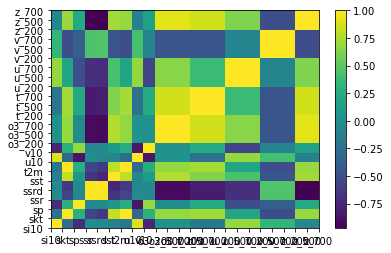

In [10]:
plt.pcolormesh(v,v,correlation_matrix.transpose())
plt.colorbar()
plt.show()

Looking at the above code, variables which have similar behaviors are either ones on different levels or t2m and skt. So we will compute regressions for each level seperately, ignoring skin temperature for now.

## Linear regression model

In [11]:
# import os
# os._exit(00)

In [35]:
import xarray as xr
import pandas as pd
import itertools
from tqdm import tqdm
from modules import *
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', w4.fmt)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Normalize the variables this will be reversed later
ds = xr.open_dataset('processed_data/environmental.nc')

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))

mean_vec = ds.mean(dim='time')
std_vec = ds.std(dim='time')

ds = (ds-mean_vec)/std_vec
ds
# for v in ds:
#     plt.plot(ds.time, ds[v].mean(dim=('x','y')))
#     plt.title(v)
#     plt.show()

seaice = w3.load_data(['seaice'],projection='SouthPolarStereo', temporal_resolution='annual',temporal_decomposition='anomalous',detrend='raw')
ds['seaice'] = seaice['seaice']

v = [v for v in ds]
x_surface = ['si10','sp', 'ssr', 'sst','t2m','u10','v10']
x_subset =  ['t2m','u10', 'v10', 'si10', 'sp']
x_200 = [vi for vi in v if '_200' in vi]
x_500 = [vi for vi in v if '_500' in vi]
x_700 = [vi for vi in v if '_700' in vi]

for x in [x_surface, x_200, x_500, x_700, x_subset]:
    print('Regressing variables: ', x)
    regression_results = w4.multiple_fast_regression(ds, 'seaice', x)
    v2 = [vi for vi in regression_results if vi not in v]
    for vi in v2:
        ds[vi] = regression_results[vi]
ds

Regressing variables:  ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10']
Finding coefficients for ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 11725.74it/s]


Predicting SIC
Regressing variables:  ['o3_200', 't_200', 'u_200', 'v_200', 'z_200']
Finding coefficients for ['o3_200', 't_200', 'u_200', 'v_200', 'z_200'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:09<00:00, 10696.77it/s]


Predicting SIC
Regressing variables:  ['o3_500', 't_500', 'u_500', 'v_500', 'z_500']
Finding coefficients for ['o3_500', 't_500', 'u_500', 'v_500', 'z_500'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:09<00:00, 10690.01it/s]


Predicting SIC
Regressing variables:  ['o3_700', 't_700', 'u_700', 'v_700', 'z_700']
Finding coefficients for ['o3_700', 't_700', 'u_700', 'v_700', 'z_700'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:09<00:00, 10754.80it/s]


Predicting SIC
Regressing variables:  ['t2m', 'u10', 'v10', 'si10', 'sp']
Finding coefficients for ['t2m', 'u10', 'v10', 'si10', 'sp'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:10<00:00, 10324.94it/s]


Predicting SIC


<xarray.Dataset>
Dimensions:                                    (time: 41, x: 316, y: 332)
Coordinates:
  * time                                       (time) datetime64[ns] 1979-01-...
  * y                                          (y) int32 4350000 ... -3925000
  * x                                          (x) int32 -3950000 ... 3925000
Data variables:
    si10                                       (time, y, x) float64 nan ... 2...
    skt                                        (time, y, x) float64 nan ... -...
    sp                                         (time, y, x) float64 nan ... 0...
    ssr                                        (time, y, x) float64 nan ... -...
    ssrd                                       (time, y, x) float64 nan ... -...
    sst                                        (time, y, x) float64 nan ... -...
    t2m                                        (time, y, x) float64 nan ... -...
    u10                                        (time, y, x) float64 nan ... 2...
    v10                                        (time, y, x) float64 nan ... -...
    o3_200                                     (time, y, x) float64 nan ... 4...
    o3_500                                     (time, y, x) float64 nan ... 4...
    o3_700                                     (time, y, x) float64 nan ... 4.27
    t_200                                      (time, y, x) float64 nan ... 0...
    t_500                                      (time, y, x) float64 nan ... 0...
    t_700                                      (time, y, x) float64 nan ... 0...
    u_200                                      (time, y, x) float64 nan ... 2...
    u_500                                      (time, y, x) float64 nan ... 2...
    u_700                                      (time, y, x) float64 nan ... 2...
    v_200                                      (time, y, x) float64 nan ... 0...
    v_500                                      (time, y, x) float64 nan ... 0...
    v_700                                      (time, y, x) float64 nan ... 0...
    z_200                                      (time, y, x) float64 nan ... 0...
    z_500                                      (time, y, x) float64 nan ... 0...
    z_700                                      (time, y, x) float64 nan ... 0...
    seaice                                     (x, y, time) float64 0.0 ... nan
    prediction_si10_sp_ssr_sst_t2m_u10_v10     (x, y, time) float64 nan ... nan
    regr_coef_si10                             (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_sp                               (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_ssr                              (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_sst                              (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_t2m                              (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_u10                              (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_v10                              (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_error                            (x, y) float64 0.0 0.0 ... 0.0
    prediction_si10                            (x, y, time) float64 nan ... nan
    prediction_sp                              (x, y, time) float64 nan ... nan
    prediction_ssr                             (x, y, time) float64 nan ... nan
    prediction_sst                             (x, y, time) float64 nan ... nan
    prediction_t2m                             (x, y, time) float64 nan ... nan
    prediction_u10                             (x, y, time) float64 nan ... nan
    prediction_v10                             (x, y, time) float64 nan ... nan
    prediction_o3_200_t_200_u_200_v_200_z_200  (x, y, time) float64 nan ... nan
    regr_coef_o3_200                           (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_t_200                            (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_u_200                            (x, y) float64 0.0 0.0 ... 0.0
    regr_coef_v_200                      

Plotting results for:  ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10']


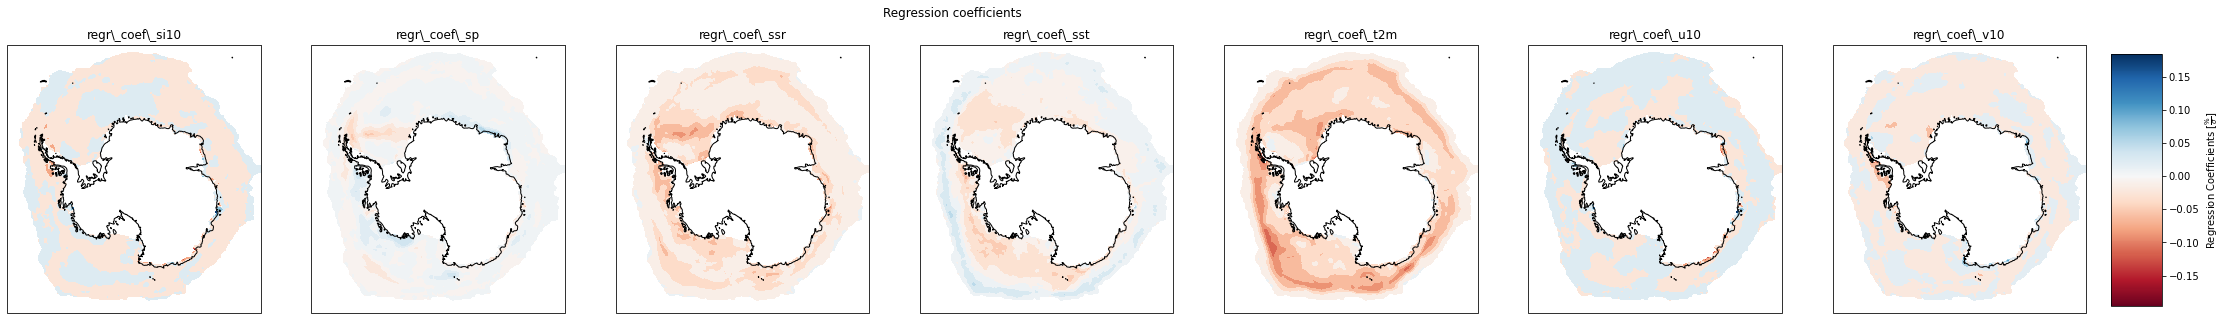

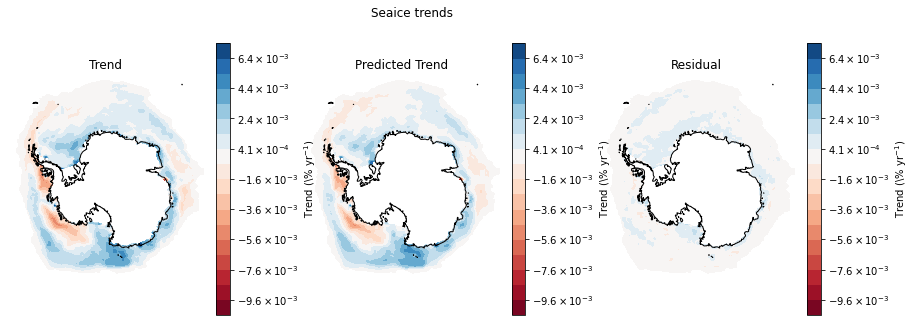

findfont: Font family ['computer modern'] not found. Falling back to DejaVu Sans.


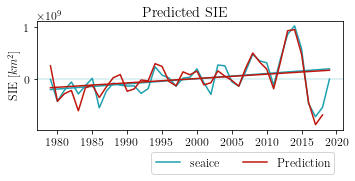

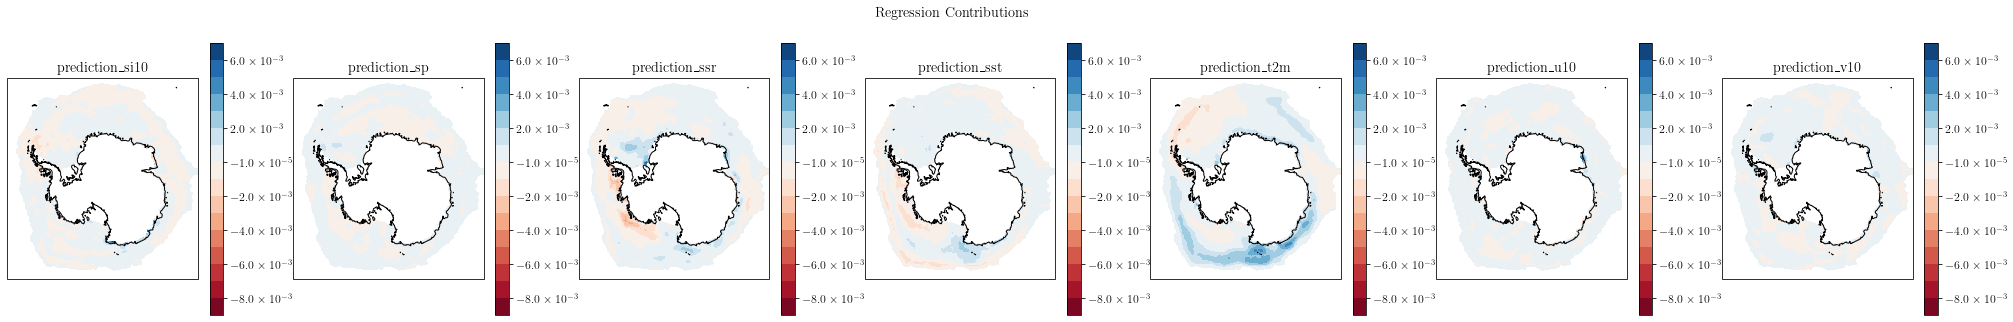

Plotting results for:  ['o3_200', 't_200', 'u_200', 'v_200', 'z_200']


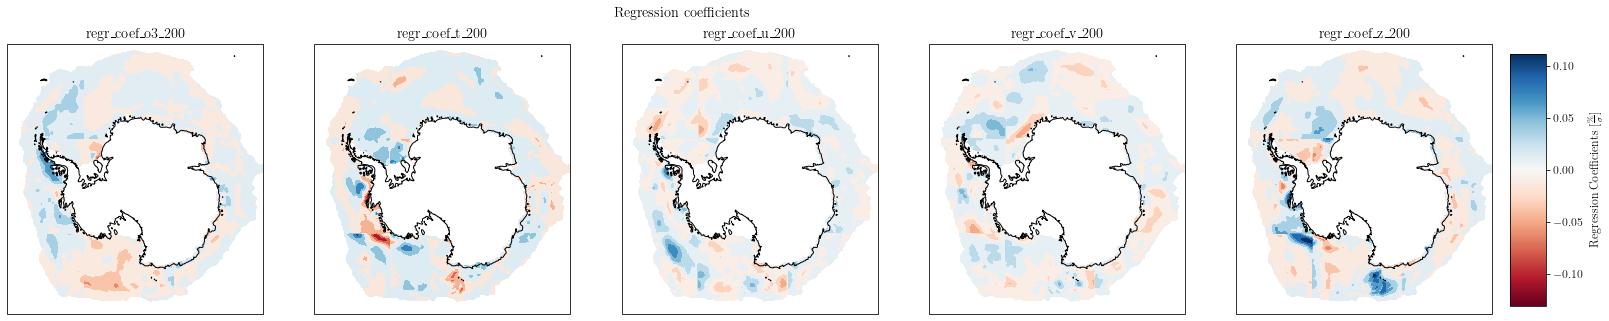

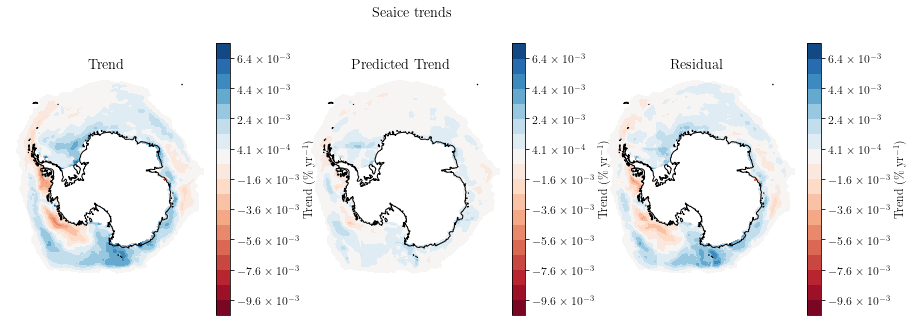

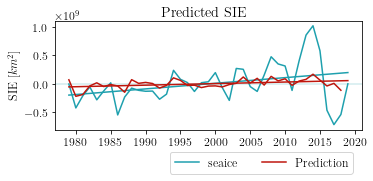

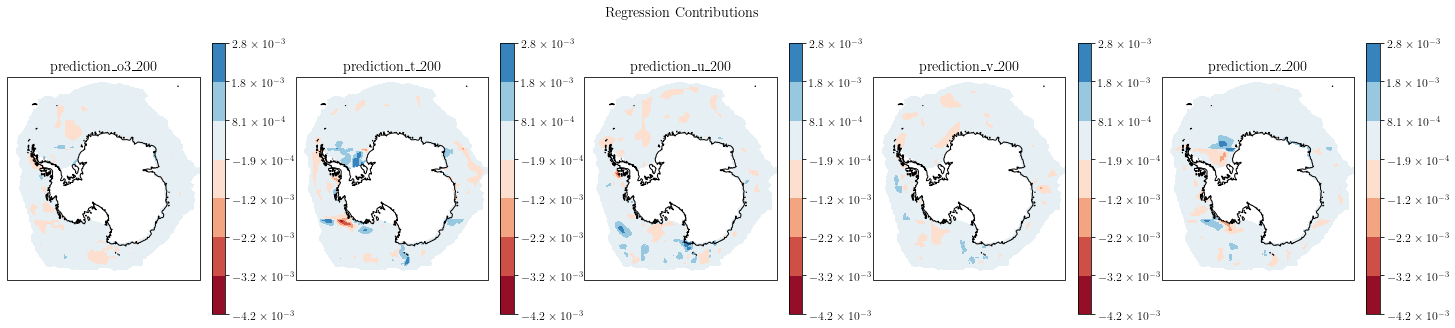

Plotting results for:  ['o3_500', 't_500', 'u_500', 'v_500', 'z_500']


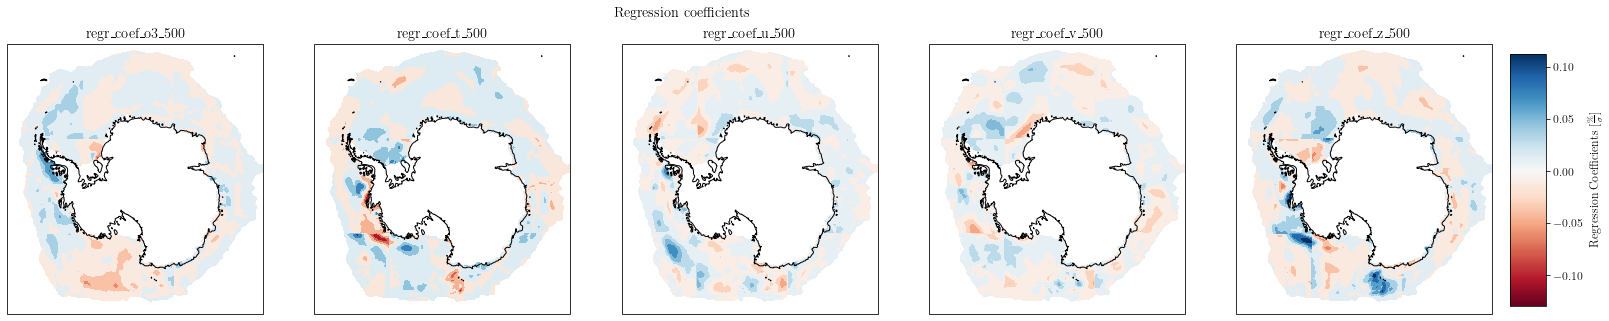

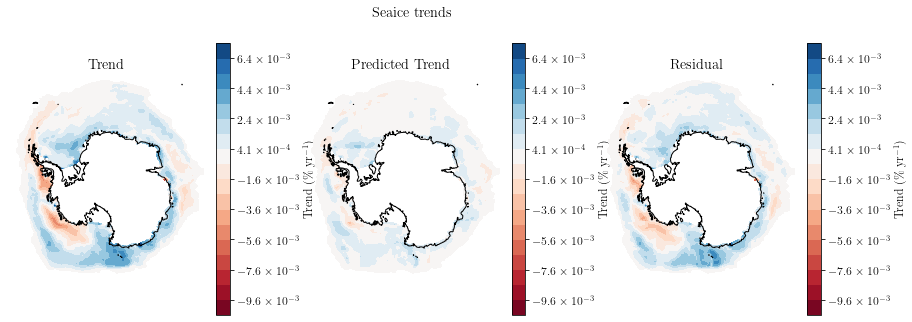

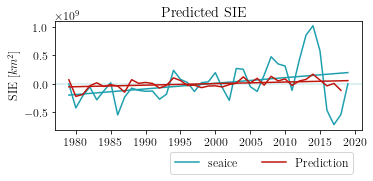

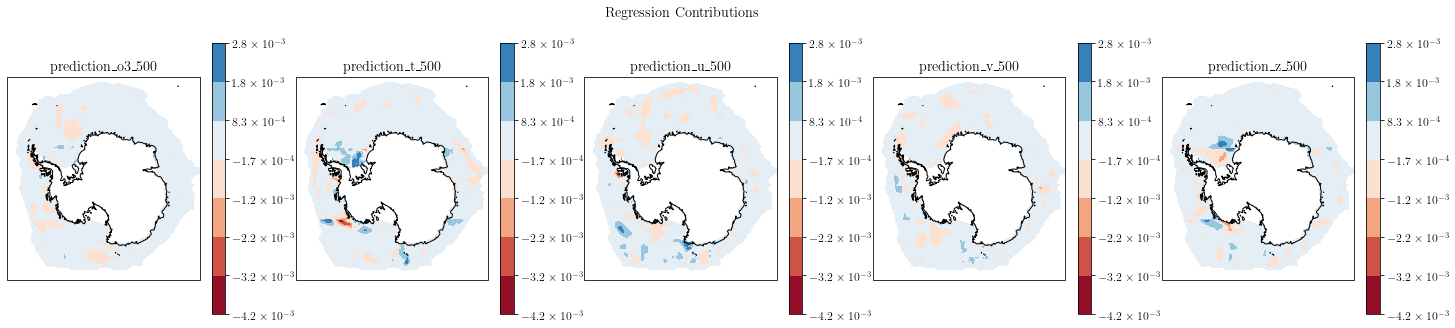

Plotting results for:  ['o3_700', 't_700', 'u_700', 'v_700', 'z_700']


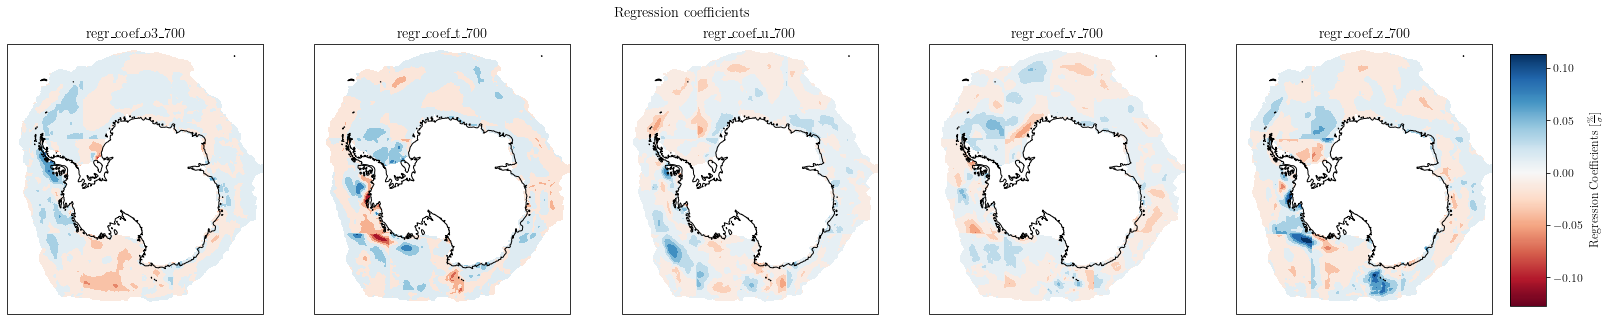

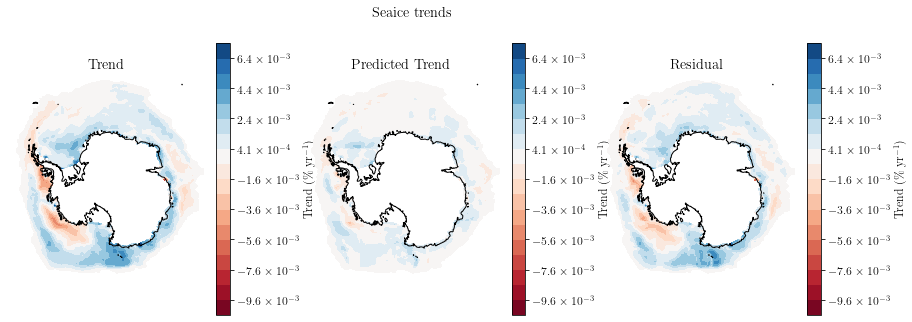

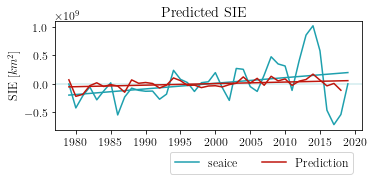

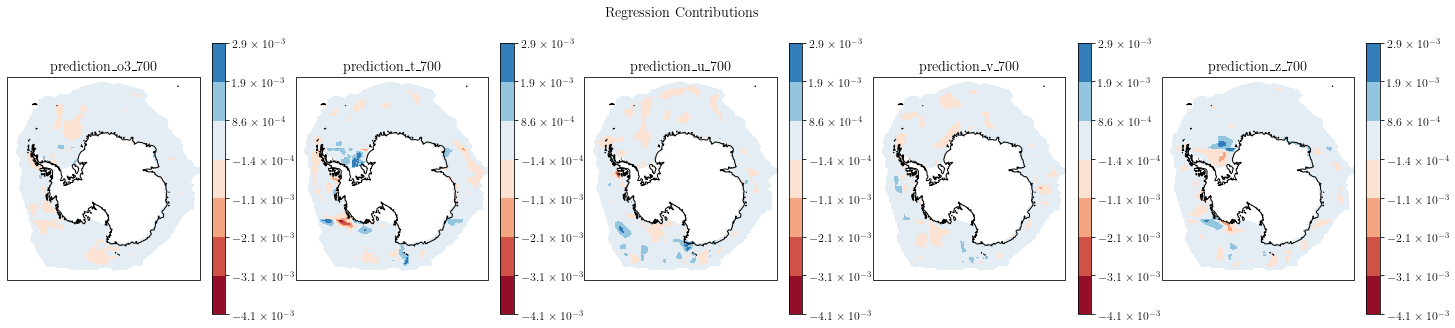

Plotting results for:  ['t2m', 'u10', 'v10', 'si10', 'sp']


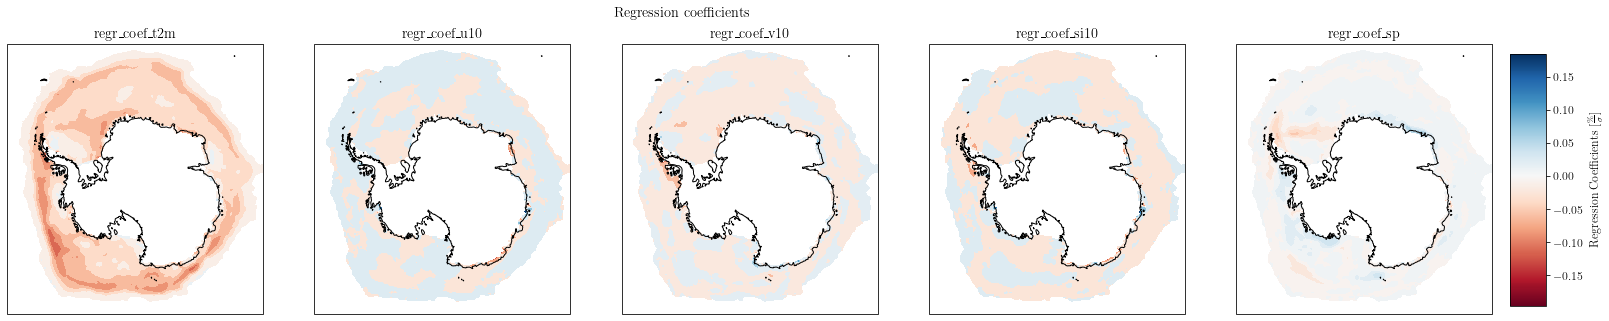

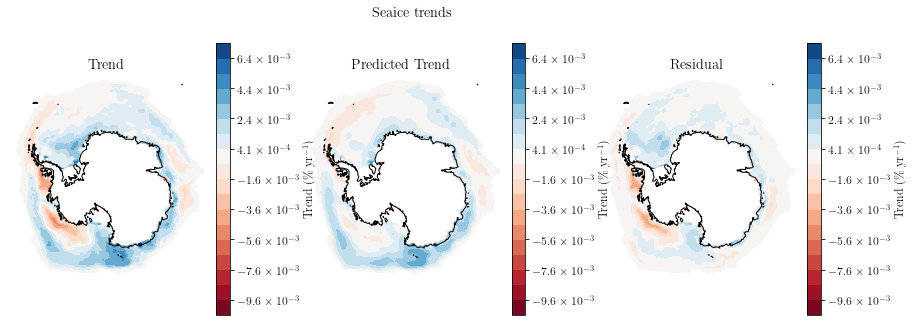

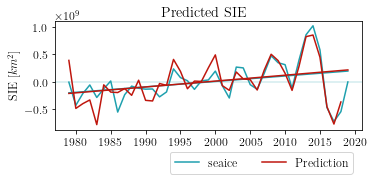

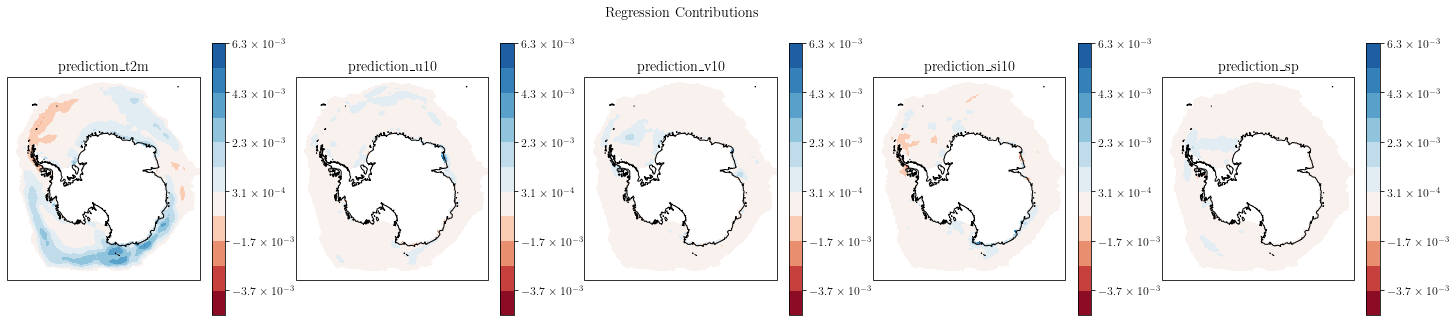

In [14]:
for x in [x_surface, x_200, x_500, x_700, x_subset]:
    print('Plotting results for: ', x)
    w4.plotting(ds, 'seaice',x)

In [37]:
regression_results = w4.multiple_fast_regression(ds, 'seaice', x_surface)
stats = w4._get_stats(regression_results, 'seaice' ,x_surface)
stats.name = 'Quality of Regression'
stats.index = [col.replace('_', ' ').capitalize() for col in stats.index]
stats.to_latex('..\Environmental-Impact-On-Sea-Ice\\index_stats_0.tex',  escape=False, column_format='l'*(len(stats.index)+1))
stats

Finding coefficients for ['si10', 'sp', 'ssr', 'sst', 't2m', 'u10', 'v10'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 11806.44it/s]


Predicting SIC


Spatial correlation                    0.97
Temporal correlation                   0.94
Predicted trend        $8.32 \times 10^{6}$
Actual trend           $1.07 \times 10^{7}$
Name: Quality of Regression, dtype: float64

In [39]:
results = w4.indicies_stats(ds, regression_results, 'seaice', x_surface,'SouthPolarStereo', 'annual','anomalous','raw')

Finding coefficients for ['si10'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13670.61it/s]


Predicting SIC
Finding coefficients for ['sp'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13651.21it/s]


Predicting SIC
Finding coefficients for ['ssr'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13649.51it/s]


Predicting SIC
Finding coefficients for ['sst'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 16795.28it/s]


Predicting SIC
Finding coefficients for ['t2m'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13485.28it/s]


Predicting SIC
Finding coefficients for ['u10'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:07<00:00, 13697.89it/s]


Predicting SIC
Finding coefficients for ['v10'] against seaice


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:08<00:00, 12974.39it/s]


Predicting SIC


In [42]:
# results = results.sort_values('individual_Predicted_Trend', ascending=False)
results.columns = [col.replace('_', ' ').capitalize() for col in results.columns]
results.transpose().to_latex('..\Environmental-Impact-On-Sea-Ice\\index_stats_1.tex',  escape=False, column_format='l'*(len(results.index)+1))
results.transpose()

,sst,t2m,sp,ssr,u10,v10,si10
Individual spatial correlation,0.80,0.69,0.22,0.88,0.32,0.34,0.42
Individual temporal correlation,0.76,0.87,0.20,0.63,0.32,0.05,0.17
Individual actual trend,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$
Individual predicted trend,$1.06 \times 10^{7}$,$1.00 \times 10^{7}$,$1.64 \times 10^{6}$,$3.87 \times 10^{5}$,$2.62 \times 10^{5}$,$-2.65 \times 10^{4}$,$-3.19 \times 10^{6}$
Spatial correlation,0.54,0.56,-0.04,0.83,0.00,-0.14,0.25
Temporal correlation,0.61,0.86,0.12,0.66,0.01,0.13,0.03
Actual trend,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$,$1.07 \times 10^{7}$
Predicted trend,$-5.04 \times 10^{5}$,$7.66 \times 10^{6}$,$3.34 \times 10^{5}$,$4.34 \times 10^{5}$,$9.67 \times 10^{5}$,$3.91 \times 10^{5}$,$-9.53 \times 10^{5}$


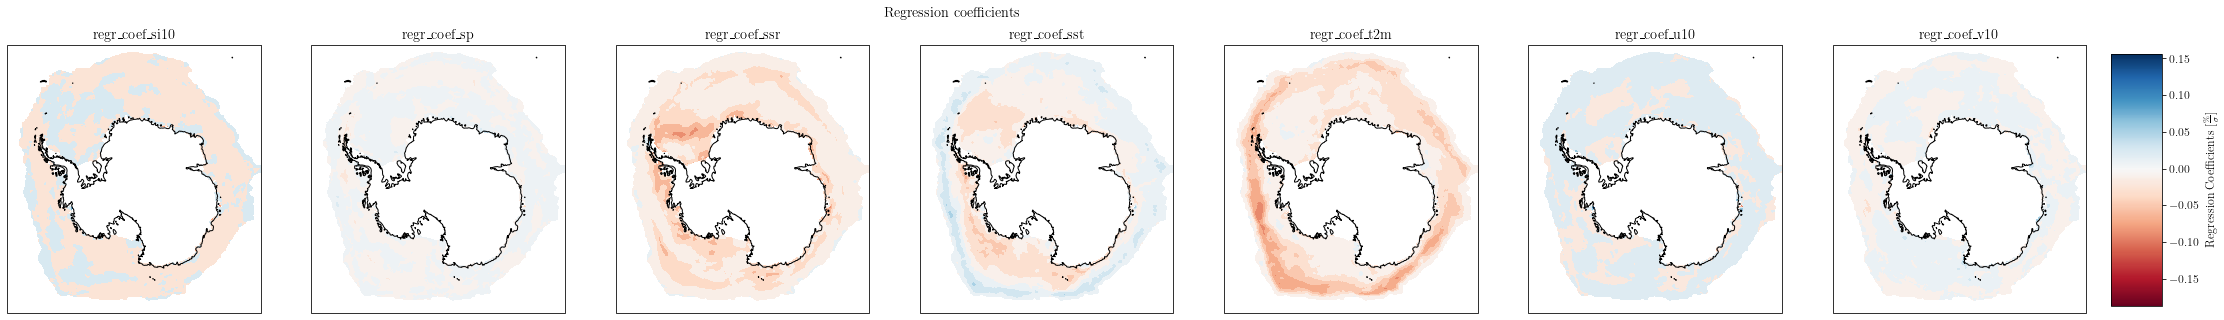

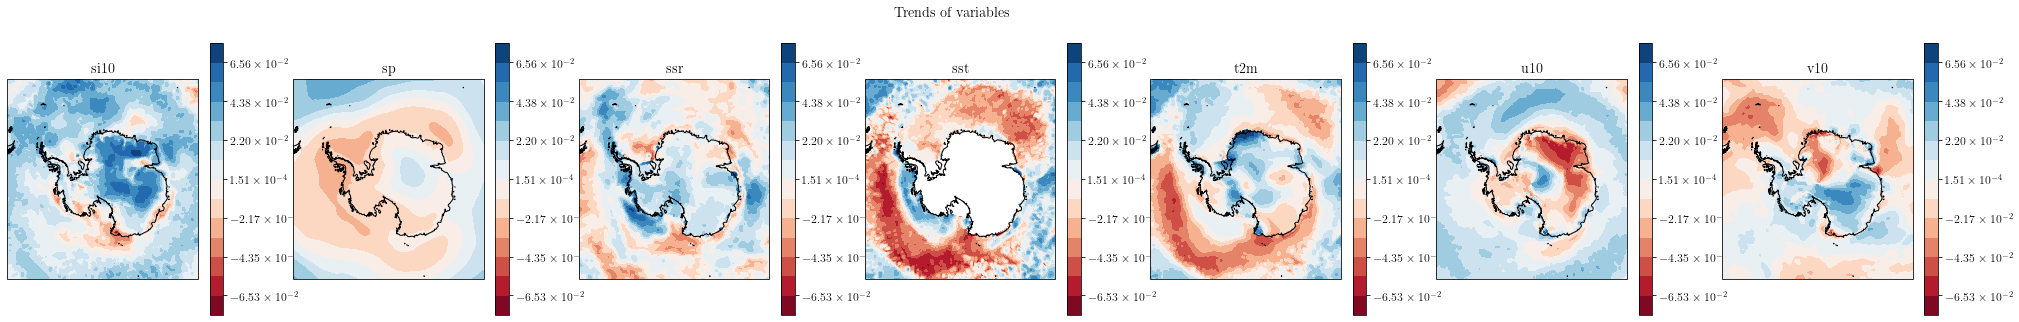

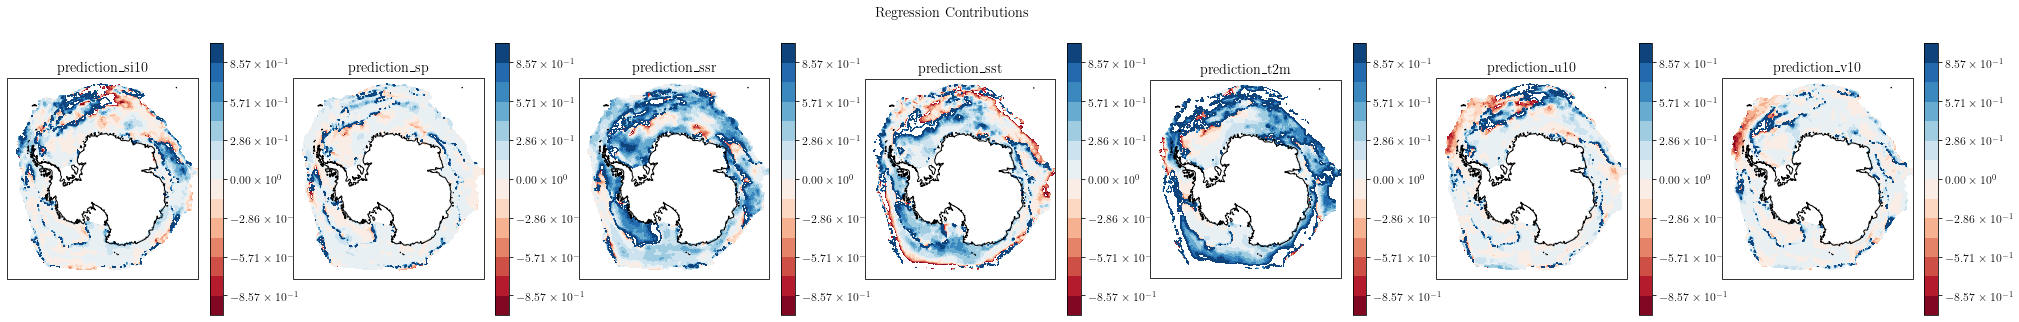

In [65]:
w4.more_plotting(regression_results, 'seaice' ,x_surface)